# Gaussian kernel density estimation

## Kernel density estimator
Let $\{X_1, \cdots, X_N \}$ be a set of independent realizations from an unknown continuous probability density function $f$ in a certain space $\mathcal{X} \subset \mathbb{R}$. A kernel density estimator for $f$ is defined as

$$
\begin{array}{cc}
\displaystyle \hat{f}(x; h) = \frac{1}{Nh}\sum_{i=1}^N{\kappa\left( \frac{x - X_i}{h}\right)}, & x \in \mathbb{R}
\tag{1.1}
\end{array}
$$

where the **kernel function** $\kappa$ is (usually) a symmetric density function in $\mathbb{R}$, $\kappa(-x) = \kappa(x)$. $h$ is a positive smoothing parameter called **bandwidth**. Larger values of $h$ produce smoother estimations, while lower values produce more sinuous estimations. There is a bias-variance tradeoff when choosing $h$.

While both the kernel function and the bandwidth affect the performance of the density estimator, the latter is much more relevant. In practice, one usually just pick a Gaussian kernel and devotes greater effort to the choice of the smoothing parameter $h$.

## Gaussian kernel
The **Gaussian kernel density estimator** arises when $\kappa$ is the **pdf** of a standard normal distribution. Thus, the estimator is of the form

$$
 \begin{array}{cc}
  \displaystyle \hat{f}(x; h) = \frac{1}{Nh}\sum_{i=1}^N{\varphi\left( \frac{x - X_i}{h}\right)}, & x \in \mathbb{R}
 \end{array}
$$

where

$$
\displaystyle \varphi(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
$$

Putting all the pieces together, the estimator results in:

$$
 \hat{f}(x;h) = \frac{1}{Nh}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}}
$$

which can be seen as the average of $N$ normal distributions centered at each of the $X_i$ with a common standard deviation $h$

$$
 \hat{f}(x;h) = \frac{1}{N}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}h}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}}
 \tag{1.2}
$$

In practice, $x$ is just an equally spaced grid of values in an interval of the real line.

## Error measurement

A very popular criteria to assess the performance of an estimator $\hat{f}$ is the **Mean Integrated Squared Error**

$$
\text{MISE}(t) = \mathbb{E}_f\int{[\hat{f}(x; h) - f(x)]^2}dx
$$

which can be decomposed in the integrated squared bias and integrated variance

$$
\text{MISE}(h) = \int{(\underbrace{\mathbb{E}_f[\hat{f}(x;h)] - f(x)}_{\text{pointwise bias of } \hat{f}})^2}dx + 
\int{\underbrace{Var_f(\hat{f}(x;h))}_{\text{pointwise variance of } \hat{f}}}dx
$$

In the context of a Gaussian kernel, an asymptotic first-order approximation for the **MISE** is given by

$$
\frac{1}{4} h^4 \lVert f'' \rVert^2 + \frac{1}{2N\sqrt{\pi t}}
\tag{1.3}
$$

where $\lVert f'' \rVert^2 = \int(f''(x))^2dx$.

## *Optimal* bandwidth for the Gaussian KDE

It is possible to show the value of $h$ that minimizes (1.3) asymptotically is

$$
h^* = \left(\frac{1}{2N\sqrt{\pi} \lVert f'' \rVert^2} \right)^{1 / 5}
$$

We can observe the optimal $h^*$ in a Gaussian KDE requires $\lVert f'' \rVert^2$ for its calculation. However, it is an unknown quantity because $f$ is unknown. 

A frequently used **Gaussian rule of thumb** is obtained assuming that $f$ is the density of a random variable following a $\mathcal{N}(\hat{\mu}, \hat{\sigma}^2)$. In this scenario, $\lVert f''\rVert^2 = \hat{\sigma}^{-5}\pi^{-1/2}3/8$, and then the rule suggests

$$
h_{rot} = \left(\frac{4\hat{\sigma}^5}{3N} \right)^{1/5} \approx 1.058N^{0.2}\hat{\sigma}
$$

A robust rule of thumb has been proposed to mitigate the effect of possible outliers and/or more serious deviations from normality

$$
h_{Rot} = \left(\frac{4S^5}{3N} \right)^{1/5}
$$

where $S = \min\{\hat{\sigma}, \frac{R}{1.34}\}$ is a robust measure of the dispersion in the observations. $R$ represents the inter-quartile range, defined as

$$
R = \underbrace{X_{([0.75N])}}_{\text{75% quantile}} - \underbrace{X_{([0.25N])}}_{\text{25% quantile}}
$$

### **Remarks**

1. We start using a non-parametric method to estimate a density because we want to avoid the rigid structure imposed by assuming that our sample comes from a particular pre-specified distribution. We end up assuming a normal distribution to obtain a plausible rule for $h$. 
2. Gaussian rule of thumb and Robust gaussian rule of thumb can be found in Silverman, B. W. 1998, *Density Estimation for Statistics and Data Analysis*. Monographs on Statistics and Applied Probability. Chapman & Hall/CRC.

# Naive (but straight) implementation of Gaussian KDE

In [3]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

def gaussian_kde(x, h=None):
    
    """
    Naive, inefficient, but straightforward Gaussian KDE
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of the variable for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses gaussian rule of thumb.
    
    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    """
    
    x_sd = np.std(x)
    x_len = len(x)
    
    grid_len = 1000
    grid_min = np.min(x) - 1 * x_sd
    grid_max = np.max(x) + 1 * x_sd
    
    grid = np.linspace(grid_min, grid_max, num=grid_len)
    
    pdf_mat = np.zeros((x_len, grid_len))
    
    
    if h is None:
        s = min(x_sd, stats.iqr(x) / 1.34)
        h = 1.058 * s * x_len ** (-0.2)    
    
    for i in range(0, x_len):
        mu = x[i]
        pdf_mat[i, :] = np.exp(-0.5 * ((grid - mu) / h) ** 2) / (np.sqrt(2 * np.pi) * h)
     
    pdf = np.mean(pdf_mat, axis=0)
    
    return grid, pdf        

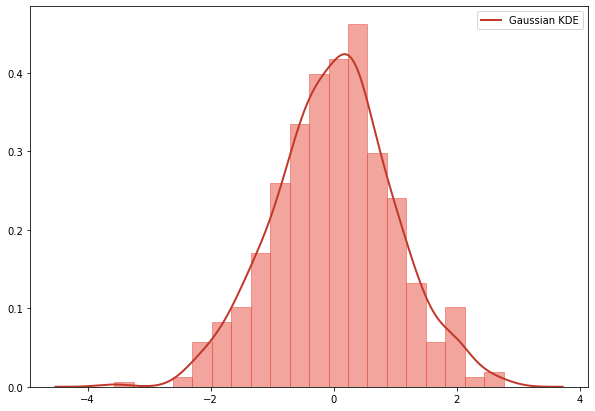

In [7]:
POMENGRATE = "#c0392b"
ALIZARIN = "#e74c3c"

np.random.seed(1234)

rvs = np.random.normal(size=500)
xval, yval = gaussian_kde(rvs)

plt.plot(xval, yval, linewidth = 2,
         color=POMENGRATE, label="Gaussian KDE")
plt.hist(rvs, density=True, bins=20,
         alpha=0.5, Color=ALIZARIN)
plt.legend()
plt.show()